# 6. BBox Regression Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dataset import *
from vnet import *
from training import *
from niiutility import show_image, show_batch_image

%matplotlib inline
%load_ext autoreload
%autoreload 2

## 6.1 Setup Torch Global Variable, load memory map 

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, sampler, SubsetRandomSampler
from torchvision import transforms, utils

import torch.nn.functional as F  # useful stateless functions
import torchvision.transforms as T

#------------------------------- GLOBAL VARIABLES -------------------------------------#

USE_GPU = True
BATCH_SIZE = 2
NUM_WORKERS = 6
NUM_TRAIN = 80
LEARNING_RATE = 1e-2

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    print('using GPU for training')
else:
    device = torch.device('cpu')

* BvMaskDataset, return image and bbox tuple of 6

In [3]:
#-------------------------LOAD THE DATA SET-------------------------------------------#
regen = False

if regen:

    data_index = np.arange(107)
    data_index = np.delete(data_index, 46)
    data_idnex = np.random.shuffle(data_index)
else:
    data_index = np.array ([50,17,81,39,36,88,33,77,7,1,52,43,34,40,41,18,72,58,51,
                  63,78,35,16,79,0,89,70,67,60,13,76,8,2,47,4,97,29,85,32,
                  55,30,49,44,11,101,22,37,10,92,68,5,64,105,95,20,38,99,
                  84,86,91,96,71,98,104,45,69,103,27,19,59,73,106,93,24,80,
                  66,28,90,3,102,31,26,94,62,54,48,12,61,87,42,65,74,53,57,
                  14,56,83,100,25,6,75,82,23,9,21,15])
    
dataset_trans = BvMaskDataset(data_index, 
                         transform=transforms.Compose([
                             RandomFilp(0.5),
                             RandomAffine(180, 15, 1.2),
                             downSample(2)
                         ])
                     )

#-------------------------CREATE DATA LOADER FOR TRAIN AND VAL------------------------#

data_size = len(dataset_trans)
train_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE, \
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)),\
                    num_workers=NUM_WORKERS)
validation_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE,
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN,data_size)),\
                    num_workers=NUM_WORKERS)

* Print first 4 batch of data

0 torch.Size([2, 1, 96, 128, 128]) torch.Size([2, 6])


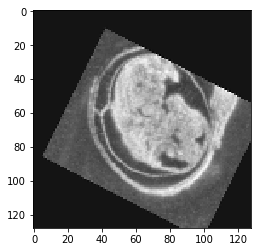

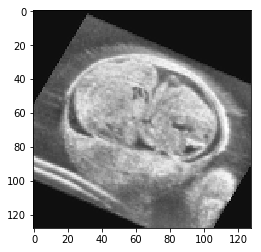

1 torch.Size([2, 1, 96, 128, 128]) torch.Size([2, 6])


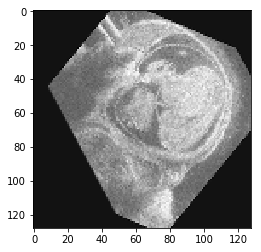

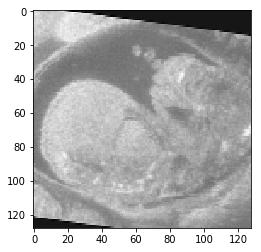

2 torch.Size([2, 1, 96, 128, 128]) torch.Size([2, 6])


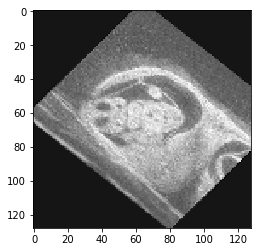

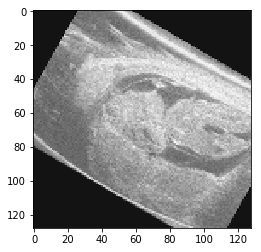

3 torch.Size([2, 1, 96, 128, 128]) torch.Size([2, 6])


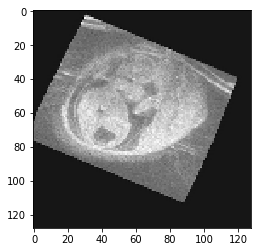

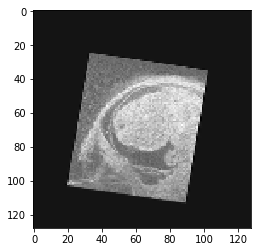

In [4]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(), \
          sample_batched['label'].size())
    show_batch_image(sample_batched['image'],BATCH_SIZE,None)

    # observe 4th batch and stop.
    if i_batch == 3:
        break

In [6]:
from vnet import LNet

LoadCKP = False

CKPPath = 'checkpoint2019-04-05 19:46:58.793496.pth'

model = LNet(img_size=(96, 128, 128), out_size=6)
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=50, verbose=True)
logger = {'train':[], 'validation':[]}

if LoadCKP:
    loadckp(model, optimizer, scheduler, logger, CKPPath, device=device)

In [ ]:
#-------------------------NEW MODEL INIT WEIGHT--------------------------------------#

from loss import *

train(model, train_loader, validation_loader, optimizer, scheduler,\
      device=device, dtype=dtype, lossFun=MSE, logger=logger, epochs=5000, startepoch=0)

In [ ]:
#-------------------------SAVE THE MODEL STATE DICT----------------------------------#
PATH = 'LNET-404.pth'
torch.save(model.state_dict(), PATH)